In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def add_gaussian_noise(img, sigma):
    # Convert to float for safe addition
    noisy = img.astype(np.float64)
    # Generate Gaussian noise (mean = 0, std = sigma)
    noise = np.random.normal(0, sigma, img.shape)
    # Add noise
    noisy += noise
    # Clip to valid range (0–255 for 8-bit images)
    noisy = np.clip(noisy, 0, 255)
    return noisy.astype(np.uint8)


img = cv2.imread('taj_clean.jpg', cv2.IMREAD_GRAYSCALE)
noisy_img = add_gaussian_noise(img, sigma=20)
cv2.imwrite('taj_noisy.png', noisy_img)

True

In [3]:
def process_pixel(img, i, j, k=9, b=25.0):
    r = k//2
    padded = np.pad(img, r, mode='constant', constant_values=0)
    pi, pj = i + r, j + r
    K1 = padded[pi-r:pi+r+1, pj-r:pj+r+1].astype(np.float64)
    mew = padded[pi-1:pi+1+1, pj-1:pj+1+1].astype(np.float64)
    mew = (1/9)*(mew.sum())
    a = padded[pi, pj]
    a = mew
    K2 = np.exp(-((K1 - a)**2) / (2.0 * (b**2)))
    mn = K2.min()
    mx = K2.max()
    K3 = (K2 - mn) / (mx - mn + 1e-12)
    K4 = (K3 >= 0.8).astype(np.float64)
    wsum = K4.sum()
    if wsum == 0:
        return float(a)
    patch = K1
    return float((K4 * patch).sum() / wsum)

def reconstruct_image(img, k=9, b=25.0):
    img_arr = img.astype(np.float64)
    H, W = img_arr.shape
    out = np.zeros_like(img_arr)
    for i in range(H):
        for j in range(W):
            out[i, j] = process_pixel(img_arr, i, j, k=k, b=b)
    return out


In [4]:
im2 = reconstruct_image(noisy_img,9,50)
bilateral = cv2.bilateralFilter(noisy_img, 9, 50, 50)

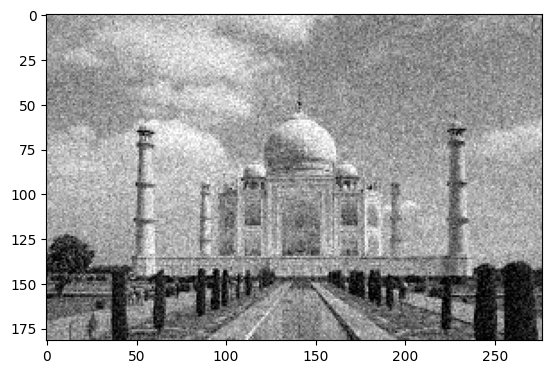

In [136]:
plt.imshow(noisy_img, cmap = "gray")

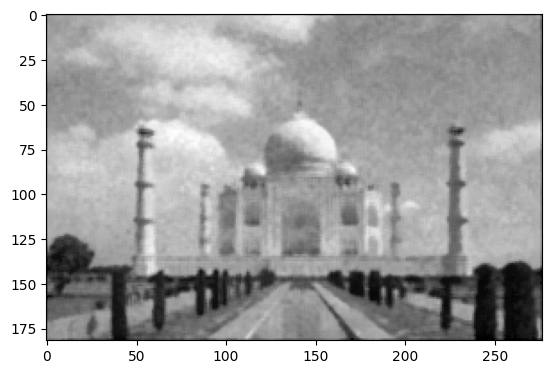

In [137]:
plt.imshow(im2,cmap = "gray")

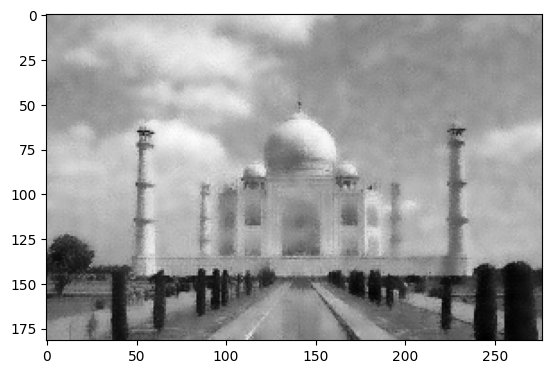

In [138]:
plt.imshow(bilateral,cmap = "gray")

In [139]:
im3 = reconstruct_image(im2,9,50)

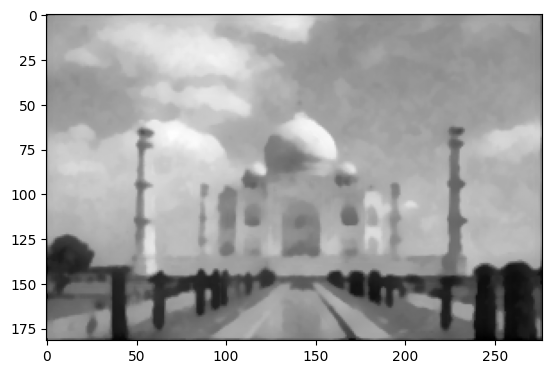

In [140]:
plt.imshow(im3,cmap = "gray")

In [141]:
im4 = reconstruct_image(im3,9,50)

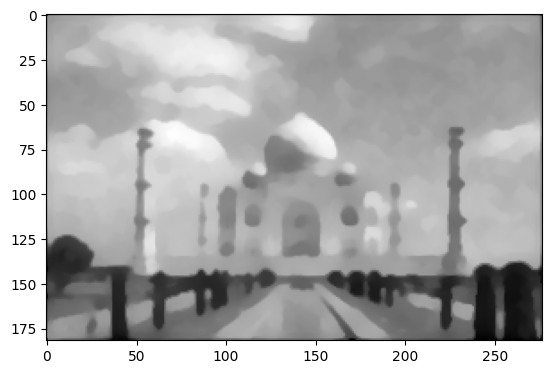

In [142]:
plt.imshow(im4,cmap = "gray")

In [143]:
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
def eval_pair(clean, recon):
    return psnr(clean, recon, data_range=clean.max()-clean.min()), \
           ssim(clean, recon, data_range=clean.max()-clean.min())


In [144]:
eval_pair(img, bilateral)

(np.float64(27.131354194557602), np.float64(0.7970509452408788))

In [145]:
eval_pair(img, im2)

(np.float64(25.315308131642542), np.float64(0.7456215668798571))

In [146]:
eval_pair(img, im3)

(np.float64(24.652714856102737), np.float64(0.7626621825217434))

In [147]:
eval_pair(img, im4)

(np.float64(23.82101218419555), np.float64(0.7324692693877091))

In [148]:
np.max(im4),np.min(im4)

(np.float64(235.1217602267215), np.float64(0.032317636195752536))

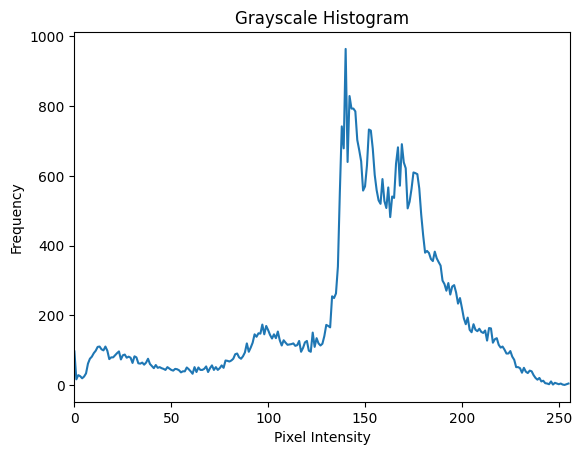

In [149]:
import cv2
import matplotlib.pyplot as plt

# Load the image in grayscale
#image = cv2.imread('image.jpg', cv2.IMREAD_GRAYSCALE)

# Compute histogram
hist = cv2.calcHist([np.array(img,dtype=np.uint8)], [0], None, [256], [0, 256])

# Plot the histogram
plt.figure()
plt.title("Grayscale Histogram")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.plot(hist)
plt.xlim([0, 256])
plt.show()


In [150]:
np.shape(img)

(182, 277)

In [151]:
np.shape(im4)

(182, 277)

In [152]:
eval_pair(img, img+1)

(np.float64(39.40982254755878), np.float64(0.9977000759296464))

In [153]:
import numpy as np

def cosine_similarity(img1, img2):
    # Flatten both images into 1D vectors
    v1 = img1.flatten().astype(np.float64)
    v2 = img2.flatten().astype(np.float64)
    
    # Subtract mean to remove brightness bias (optional but recommended)
    v1 -= v1.mean()
    v2 -= v2.mean()
    
    # Compute cosine similarity
    numerator = np.dot(v1, v2)
    denominator = np.linalg.norm(v1) * np.linalg.norm(v2)
    
    if denominator == 0:
        return 0.0
    return numerator / denominator


In [154]:
cosine_similarity(img, bilateral)

np.float64(0.9724141895242868)

In [9]:
import numpy as np

def image_covariance(img1, img2):
    # Flatten both images
    v1 = img1.flatten().astype(np.float64)
    v2 = img2.flatten().astype(np.float64)
    
    # Subtract means
    v1 -= v1.mean()
    v2 -= v2.mean()
    
    # Compute covariance
    cov = np.mean(v1 * v2)
    return cov


In [156]:
image_covariance(img, bilateral)/ (img.std() * bilateral.std())

np.float64(0.9724141895242869)

In [157]:
image_covariance(img, im2)/ (img.std() * im2.std())

np.float64(0.9569573737074497)

In [158]:
image_covariance(img, noisy_img)/ (img.std() * noisy_img.std())

np.float64(0.9212735556044664)

In [1]:
import numpy as np

def modified_bilateral(img, d=7, sigma_spatial=3.0, sigma_intensity=25.0):
    """
    Modified bilateral filter:
      - img: 2D grayscale image (numpy array, dtype uint8 or float)
      - d: kernel size (odd, e.g. 5 or 7)
      - sigma_spatial: spatial Gaussian sigma
      - sigma_intensity: intensity-domain sigma applied to (mean_p - q)
        where mean_p is the mean of the 3x3 neighborhood centered at p.
    Returns filtered image (same dtype as input).
    """
    # ensure float
    in_dtype = img.dtype
    I = img.astype(np.float64)
    H, W = I.shape
    r = d // 2

    # compute mean_p = mean of 3x3 neighborhood (including center)
    try:
        # fast path: use OpenCV if available
        import cv2
        mean_p = cv2.blur(I.astype(np.float32), ksize=(3,3)).astype(np.float64)
    except Exception:
        # fallback: sliding window average for 3x3
        pad = np.pad(I, 1, mode='reflect')
        mean_p = np.zeros_like(I)
        for i in range(H):
            for j in range(W):
                mean_p[i,j] = pad[i:i+3, j:j+3].mean()

    # pad image for patch extraction
    padded = np.pad(I, r, mode='reflect')

    # spatial kernel
    ax = np.arange(-r, r+1)
    xx, yy = np.meshgrid(ax, ax)
    S = np.exp(-(xx**2 + yy**2) / (2.0 * (sigma_spatial**2)))
    S = S / (S.sum() + 1e-12)

    # use numpy sliding windows if available for vectorized ops
    try:
        from numpy.lib.stride_tricks import sliding_window_view
        patches = sliding_window_view(padded, (d, d))  # shape (H, W, d, d)
        # compute range weights based on mean_p
        mp = mean_p[:, :, None, None]  # shape (H, W, 1, 1)
        diff = patches - mp  # broadcast
        R = np.exp(-(diff**2) / (2.0 * (sigma_intensity**2)))
        W = R * S[None, None, :, :]  # combine with spatial kernel
        W_sum = W.sum(axis=(2,3), keepdims=True)
        W_norm = W / (W_sum + 1e-12)
        out = (W_norm * patches).sum(axis=(2,3))
    except Exception:
        # fallback slower loop
        out = np.zeros_like(I)
        for i in range(H):
            for j in range(W):
                pi = i + r
                pj = j + r
                patch = padded[pi-r:pi+r+1, pj-r:pj+r+1]
                mp = mean_p[i, j]
                R = np.exp(-((patch - mp)**2) / (2.0 * (sigma_intensity**2)))
                W = R * S
                W = W / (W.sum() + 1e-12)
                out[i, j] = (W * patch).sum()

    # cast back to original dtype/range
    if np.issubdtype(in_dtype, np.integer):
        out = np.clip(out, 0, 255)
        return out.astype(in_dtype)
    else:
        return out.astype(in_dtype)

# Example usage:
# import cv2
# img = cv2.imread('lena.png', cv2.IMREAD_GRAYSCALE)
# filtered = modified_bilateral(img, d=7, sigma_spatial=3.0, sigma_intensity=25.0)
# cv2.imwrite('filtered.png', filtered)


In [5]:
filtered = modified_bilateral(noisy_img, d=9, sigma_spatial=50, sigma_intensity=50.0)

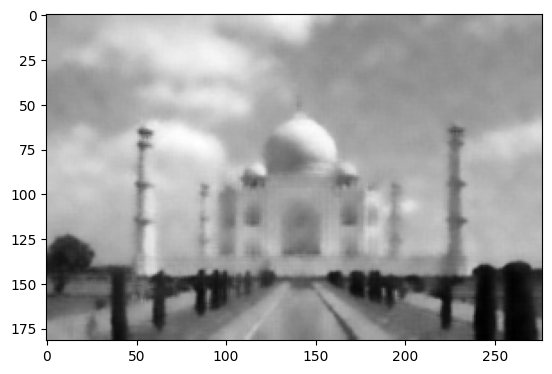

In [6]:
plt.imshow(filtered,cmap = "gray")

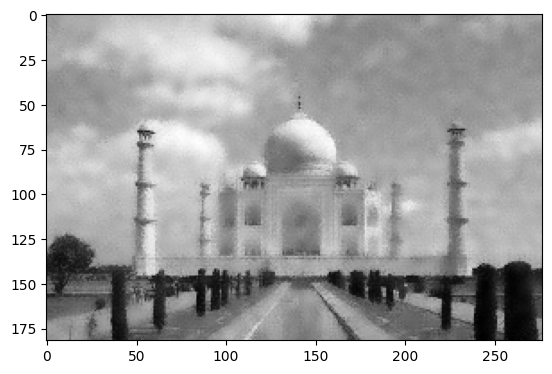

In [7]:
plt.imshow(bilateral,cmap = "gray")

In [10]:
image_covariance(img, bilateral)/ (img.std() * bilateral.std())

np.float64(0.9727615359190009)

In [11]:
image_covariance(img, filtered)/ (img.std() * filtered.std())

np.float64(0.9501200130440134)

In [1]:
import numpy as np

def process_pixel(img, i, j, k=9, b=25.0, thr=0.8):
    """
    Process one pixel for a color image (H,W,3).
    - img: numpy array float-like, shape (H,W,3)
    - i,j: pixel coordinates
    - k: kernel size (odd)
    - b: intensity-domain sigma
    - thr: threshold on normalized similarity to create binary mask
    Returns a 3-element numpy array (R,G,B) for the reconstructed pixel.
    """
    r = k // 2
    # pad with reflect for color image
    padded = np.pad(img, ((r,r),(r,r),(0,0)), mode='reflect').astype(np.float64)
    pi, pj = i + r, j + r

    # K1: k x k x 3 patch centered at (i,j)
    K1 = padded[pi-r:pi+r+1, pj-r:pj+r+1, :]  # shape (k,k,3)

    # mew: mean of 3x3 neighborhood (including center) around (i,j), per channel
    # handle border automatically due to padding
    mm = padded[pi-1:pi+2, pj-1:pj+2, :]  # shape (3,3,3)
    mew = mm.mean(axis=(0,1))             # shape (3,)

    # a is the mean vector (R,G,B)
    a = mew  # shape (3,)

    # Compute multichannel Gaussian similarity:
    # For each pixel in patch compute squared Euclidean distance in RGB to 'a'
    diff_sq = (K1 - a[None, None, :])**2           # shape (k,k,3)
    dist2 = diff_sq.sum(axis=2)                    # shape (k,k)
    K2 = np.exp(-dist2 / (2.0 * (b**2)))           # shape (k,k), values in (0,1]

    # Min-max normalize K2 -> K3 in [0,1]
    mn = K2.min()
    mx = K2.max()
    K3 = (K2 - mn) / (mx - mn + 1e-12)

    # Threshold to create binary mask K4
    K4 = (K3 >= thr).astype(np.float64)            # shape (k,k)

    wsum = K4.sum()
    # fallback: if empty mask, return original center pixel value
    if wsum == 0:
        return padded[pi, pj, :].astype(np.float64)

    # Weighted mean per channel using binary mask
    # sum over spatial dims, divide by wsum
    weighted = (K4[..., None] * K1).sum(axis=(0,1)) / wsum  # shape (3,)

    return weighted

def reconstruct_image(img, k=9, b=25.0, thr=0.8):
    """
    Reconstruct full image using process_pixel per location.
    - img: input image, shape (H,W,3) or (H,W) for grayscale
    Returns reconstructed image same shape and dtype as input.
    """
    img_arr = img.astype(np.float64)
    if img_arr.ndim == 2:
        # grayscale: adapt single-channel version using same multichannel logic with channel axis 1
        H, W = img_arr.shape
        out = np.zeros((H, W), dtype=np.float64)
        # convert to pseudo-color with single channel for reuse
        img_color = img_arr[:, :, None]
        for i in range(H):
            for j in range(W):
                val = process_pixel(img_color, i, j, k=k, b=b, thr=thr)  # returns length-1 array
                out[i, j] = val[0]
    else:
        H, W, C = img_arr.shape
        assert C == 3, "Expected 3-channel image"
        out = np.zeros_like(img_arr, dtype=np.float64)
        for i in range(H):
            for j in range(W):
                out[i, j, :] = process_pixel(img_arr, i, j, k=k, b=b, thr=thr)

    # clip and cast back to original dtype
    if np.issubdtype(img.dtype, np.integer):
        out = np.clip(out, 0, 255).astype(img.dtype)
    else:
        out = out.astype(img.dtype)
    return out


In [60]:
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
import cv2
import matplotlib.pyplot as plt

def plot_intensity_histogram(img):
    # Read the image in grayscale
    #img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Flatten image to 1D array for histogram
    pixels = img.flatten()
    
    # Compute histogram (256 bins for intensity range 0–255)
    hist, bins = np.histogram(pixels, bins=256, range=[0, 256])
    
    # Plot histogram
    plt.figure(figsize=(8, 5))
    plt.plot(hist, color='black')
    plt.title('Intensity Histogram')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()
    
    return None

# Example usage:
# hist = plot_intensity_histogram('lena.png')


def reconstruct_image_fast_gray(img, k=9, b=25.0, thr=0.6):
    """
    Fast vectorized version of the provided algorithm for grayscale images.
    - img: 2D numpy array (H,W), uint8 or float
    - k: kernel size (odd)
    - b: intensity-domain sigma (same units as image intensities)
    - thr: threshold on normalized similarity (0..1)
    Returns reconstructed image same dtype as input.
    """
    img_arr = img.astype(np.float64)
    H, W = img_arr.shape
    r = k // 2

    # pad with constant 0 to match original behavior
    padded = np.pad(img_arr, r, mode='constant', constant_values=0)

    # Extract all kxk patches: shape (H, W, k, k)
    patches = sliding_window_view(padded, (k, k))  # (H, W, k, k)

    # Compute 3x3 mean (mew) per location using sliding windows (matches original 3x3 mean)
    # For centers near border, original used padded array so this aligns.
    mew_patches = sliding_window_view(padded, (3, 3))  # shape (H+ r-1?, W+ r-1?) but when indexed at centers below it aligns
    # The top-left of mew_patches corresponds to padded[0:3,0:3] which maps to output pixel (0,0) center at padded[r,r].
    # We need mew for each original pixel (i,j) which is at padded index (i+r, j+r).
    # sliding_window_view on padded returns shape (H+2r-3+1, W+2r-3+1) = (H+2r-2, W+2r-2)
    # But simpler: extract 3x3 windows centered at the same coordinates as patches' centers:
    # We can index mew center positions by offset r-1 from patches start:
    mew = mew_patches[r-1 : r-1 + H, r-1 : r-1 + W].mean(axis=(2,3))  # shape (H, W)

    # Broadcast mew to patch shape for vectorized distance computation
    mew_exp = mew[..., None, None]  # (H, W, 1, 1)

    # Compute squared difference per element and sum over kxk patch? Original did per-element exp using scalar a,
    # where K2 = exp(-((K1 - a)^2) / (2*b^2))). Here a is scalar mew -> compute per-element similarity map.
    diff_sq = (patches - mew_exp) ** 2  # (H, W, k, k)
    K2 = np.exp(-diff_sq / (2.0 * (b ** 2)))  # (H, W, k, k)

    # Min-max normalize per-patch over k*k entries -> K3
    K2_flat = K2.reshape(H, W, -1)  # (H, W, k*k)
    mn = K2_flat.min(axis=2, keepdims=True)
    mx = K2_flat.max(axis=2, keepdims=True)
    K3_flat = (K2_flat - mn) / (mx - mn + 1e-12)
    K3 = K3_flat.reshape(H, W, k, k)

    # Threshold to get binary mask K4
    K4 = (K3 >= thr).astype(np.float64)  # (H, W, k, k)

    # Weighted mean using mask (binary)
    K4_exp = K4  # (H,W,k,k)
    weighted_sum = (K4_exp * patches).sum(axis=(2, 3))  # (H, W)
    wsum = K4.sum(axis=(2, 3))  # (H, W)

    # Where wsum == 0 fallback to mew (as original did)
    wsum_safe = wsum.copy()
    wsum_safe[wsum_safe == 0] = 1.0

    out = weighted_sum / wsum_safe

    # Replace positions where wsum==0 with mew
    zero_mask = (wsum == 0)
    out[zero_mask] = mew[zero_mask]

    # Cast back to original dtype
    if np.issubdtype(img.dtype, np.integer):
        out = np.clip(out, 0, 255).astype(img.dtype)
    else:
        out = out.astype(img.dtype)

    return out


In [67]:
img = cv2.imread('Image1.jpg', cv2.IMREAD_GRAYSCALE)

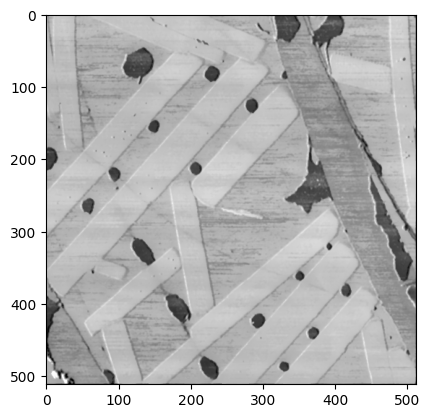

In [68]:
out = reconstruct_image_fast_gray(img, k=15, b=75.0, thr=0.9)
plt.imshow(out,cmap="gray")

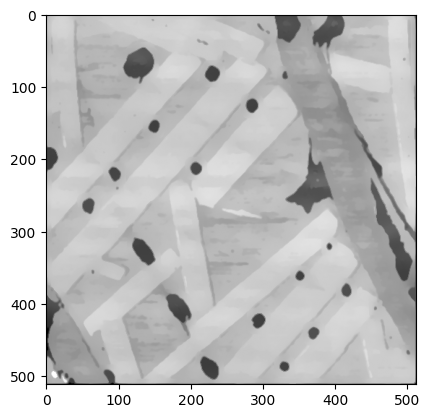

In [73]:
out = reconstruct_image_fast_gray(out ,k=15, b=75.0, thr=0.9)
plt.imshow(out,cmap="gray")

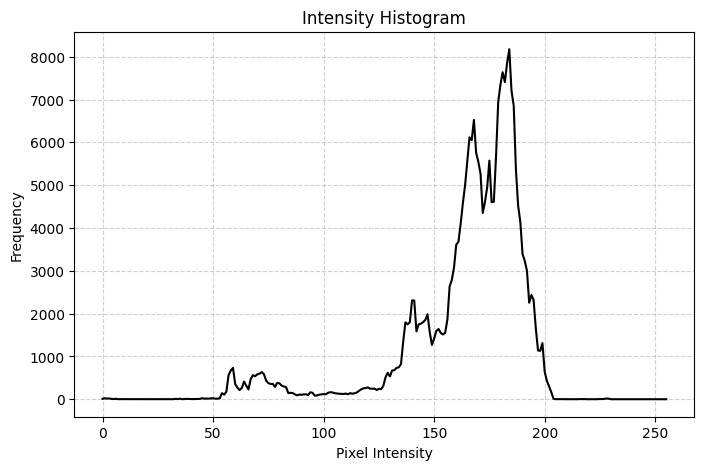

In [74]:
plot_intensity_histogram(out)